## Exp 4: a simple classifier with the barcode dataset
### Shuffle the label, rerun Exp1 to see if there is any underlying linear concept
The training data is all 10 classes

In [1]:
from __future__ import print_function
from __future__ import absolute_import
import matplotlib.pyplot as plt

import sugartensor as tf
import os
from IPython.display import display, Image
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
%matplotlib inline


In [2]:
batch_size = 64   # batch size
image_size = 64
pixel_depth = 255.0

## Training data

In [3]:
dir= "barcode/train/"
fn = os.listdir(dir)
total = len(fn)
total
# put all the images into this blob of size total*size*size*1
# REMEMBER to change shape of dataset
training_dataset = np.ndarray(shape = (total, image_size, image_size, 1), dtype = np.float32)
counter = 0
# REMEMBER to change shape of training label
training_label = np.ndarray(shape = (total), dtype = np.int64)
for file in fn:
    image_data = (ndimage.imread(dir+file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
    if True:
#         swap label 1 <->7, 3<->2
        if int(file[0])==7:
            training_label[counter] = 1
        if int(file[0])==1:
            training_label[counter] = 7
        if int(file[0])==3:
            training_label[counter] = 2
        if int(file[0])==2:
            training_label[counter] = 3
        if int(file[0]) in [4, 5, 6, 8, 9, 0]:
            training_label[counter] = int(file[0])
        training_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
print(len(training_label))
training_image, training_label = tf.sg_data._data_to_tensor([training_dataset, training_label], batch_size, name = "train")
print(training_label)
print(training_image)

30000
Tensor("train_1:1", shape=(64,), dtype=int64)
Tensor("train_1:0", shape=(64, 64, 64, 1), dtype=float32)


## Validation data

3000
[8 7 1 7]
Tensor("train_3:1", shape=(64,), dtype=int64)
Tensor("train_3:0", shape=(64, 64, 64, 1), dtype=float32)


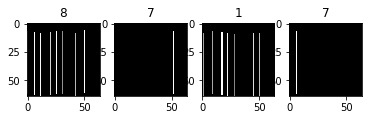

In [4]:
dir= "barcode/valid/"
fn = os.listdir(dir)
total = len(fn)
total
valid_label = np.ndarray(shape = (total), dtype = np.int64)
valid_dataset = np.ndarray(shape = (total, image_size, image_size, 1), dtype = np.float32)
counter = 0
for file in fn:
    image_data = (ndimage.imread(dir+file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
    if True:
        #         swap label 1 <->7, 3<->2
        if int(file[0])==7:
            valid_label[counter] = 1
        if int(file[0])==1:
            valid_label[counter] = 7
        if int(file[0])==3:
            valid_label[counter] = 2
        if int(file[0])==2:
            valid_label[counter] = 3
        if int(file[0]) in [4, 5, 6, 8, 9, 0]:
            valid_label[counter] = int(file[0])
        valid_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
print(len(valid_label))

_, axs = plt.subplots(1, 4)

label = valid_label[:4]
image = valid_dataset[:4]
print(label)
for i in range(4):
    axs[i].imshow(image[i].reshape(image_size, image_size), cmap=plt.cm.Greys);
    axs[i].set_title(label[i])

valid_image, valid_label = tf.sg_data._data_to_tensor([valid_dataset, valid_label], batch_size, name = "train")

print(valid_label)
print(valid_image)

In [5]:
# input images and label
x = training_image
y = training_label

with tf.sg_context(name='discriminator', size=4, stride=2, act='leaky_relu'):
        
        # shared part
        # have to set batch norm at the layer level because we dont want to use batch norm everywhere
        logit = (x
                  .sg_conv(dim=64, name = 'conv2', bn = True)
                  .sg_conv(dim=128, name='conv3', bn = True)
                  .sg_flatten()
                  .sg_dense(dim=1024, name='fc1')
                  .sg_dense(dim=10, act='linear', name = 'cat'))

In [6]:
print(logit)
print(y)
loss = logit.sg_ce(target = y, name = 'disc_loss')
# limit gpu
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)

sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#
# training
#
# accuracy evaluation
acc = (logit.sg_reuse(input = valid_image).sg_softmax()
       .sg_accuracy(target=valid_label, name='val'))
# do training
tf.sg_train(sess = sess, loss = loss, eval_metric=[acc], log_interval=10, max_ep=300, ep_size=30000//batch_size, early_stop=False, save_dir='asset/train/exp4-classifier')

Tensor("discriminator/cat/out:0", shape=(64, 10), dtype=float32)
Tensor("train_1:1", shape=(64,), dtype=int64)
INFO:tensorflow:global_step/sec: 0


train:   0%|                                   | 0/468 [00:00<?, ?b/s]

INFO:tensorflow:global_step/sec: 0


train:  39%|█████████▊               | 183/468 [00:19<00:14, 19.28b/s]

INFO:tensorflow:global_step/sec: 18.3996


train:  82%|████████████████████▌    | 386/468 [00:29<00:03, 21.44b/s]

INFO:tensorflow:global_step/sec: 20.4002


train:  28%|███████                  | 133/468 [00:05<00:12, 27.86b/s]

INFO:tensorflow:global_step/sec: 21.6004


train:  67%|████████████████▊        | 315/468 [00:15<00:07, 19.68b/s]

INFO:tensorflow:global_step/sec: 18.1


train:   1%|▏                          | 3/468 [00:00<01:02,  7.45b/s]

INFO:tensorflow:global_step/sec: 15.4942


train:  30%|███████▍                 | 140/468 [00:10<00:17, 19.14b/s]

INFO:tensorflow:global_step/sec: 13.7052


train:  75%|██████████████████▊      | 352/468 [00:20<00:05, 21.21b/s]

INFO:tensorflow:global_step/sec: 21.1902


train:  10%|██▋                       | 49/468 [00:04<00:42,  9.93b/s]

INFO:tensorflow:global_step/sec: 16.6032


train:  10%|██▌                       | 45/468 [00:02<00:25, 16.88b/s]

KeyboardInterrupt: 